## SNAP--ADC test
* ref: 10MHz
* resolution: 8bit
* sample_freq: 500MHz

### Step0: Import necessary packages

In [ ]:
import casperfpga
import logging
import time
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import numpy as np

### Step1: Connect to the SNAP board

In [ ]:
pmc_ip = '192.168.2.102'
port   = 69
logger=logging.getLogger('pmc')
logging.basicConfig(filename='snap_adc.log',level=logging.DEBUG)
pmc=casperfpga.CasperFpga(pmc_ip, port, logger=logger)

### Step2: Upload fpg file

In [ ]:
fpg = 'fpg/dsa10_2022-11-02_1656.fpg'
pmc.upload_to_ram_and_program(fpg)
# We should get system info in "upload_to_ran_and_program", but it seems there are some issues in the casperfpga
pmc.get_system_information(fpg,initialise_objects=False)

### Step3: Init adc and clk

In [ ]:
adc=pmc.adcs['snap_adc']
adc.selectADC()
adc.init(sample_rate=500,numChannel=2)
adc.rampTest(retry=True)
# set adc scales
# To-do: scale value for each channel is a 3-bits value
pmc.registers['scaling'].write_int(0)

### Step4: Read adc data from snapshot 

In [ ]:
# enable ramp mode for test
#adc.adc.test("en_ramp")
#adc.adc.test("off")

# trig the snapshot
pmc.registers['adc_trig'].write_int(0)
pmc.registers['adc_trig'].write_int(1)
# read adc data from snapshot
pmc.snapshots['adc_snap'].arm()
data = pmc.snapshots['adc_snap'].read()['data']
adc_data = data['data']
# get 8bit data from 64bit data
adc_raw = [[],[],[],[],[],[],[],[]]
for i in range(len(adc_data)):
    for j in range(8):
        tmp = adc_data[i] & 0xff
        if(tmp < 128):
            adc_raw[j].append(tmp)
        else:
            #adc_raw[j].append((tmp-128)*-1)
            adc_raw[j].append(tmp-256)
        #adc_raw[j].append(tmp)
        adc_data[i] = adc_data[i]>>8
# combine the 4 data streams into 1 stream
adc_a=[]
adc_b=[]
for i in range(len(adc_data)):
    for j in range(4):
        adc_a.append(adc_raw[j][i])
        adc_b.append(adc_raw[j+4][i])

### Step5: plot adc data

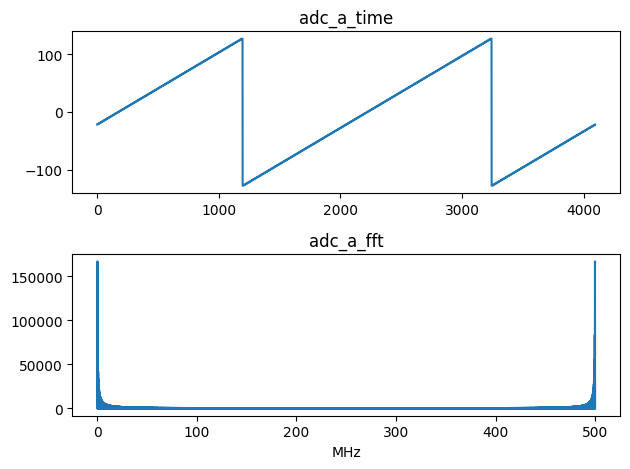

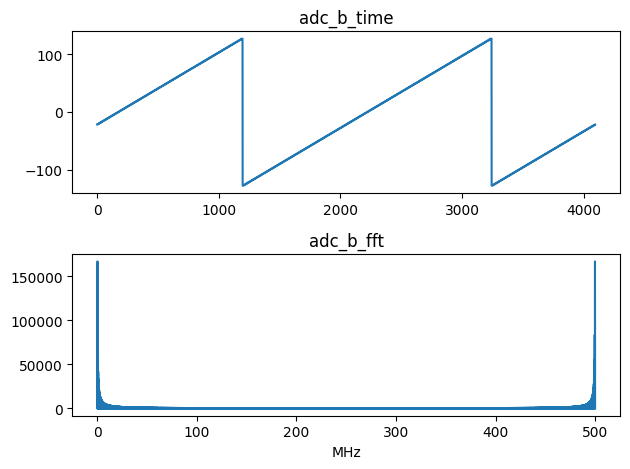

In [40]:
# set fs and Nfft
fs = 500
Nfft = len(adc_a)
x=500/4096*np.linspace(0,4096,4096)

# plot adc_a_time and adc_a_fft
plt_a_time = plt.subplot(2,1,1)
plt.plot(adc_a)
plt.title('adc_a_time')
plt_a_fft = plt.subplot(2,1,2)
a = np.array(adc_a)
fft_a = fft(a)
plt.plot(x,abs(fft_a))
plt.title('adc_a_fft')
plt.xlabel('MHz')
plt.tight_layout()
plt.show()

# plot adc_b_time and adc_b_fft
plt_b_time = plt.subplot(2,1,1)
plt.plot(adc_b)
plt.title('adc_b_time')
plt_b_fft = plt.subplot(2,1,2)
b = np.array(adc_b)
fft_b = fft(b)
plt.plot(x,abs(fft_b))
plt.title('adc_b_fft')
plt.xlabel('MHz')
plt.tight_layout()
plt.show()